In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
AB_NYC_2019 = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'

In [3]:
!wget $AB_NYC_2019

--2022-07-06 20:01:25--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv.2’

AB_NYC_2019.csv.2   100%[===================>]   6.75M  --.-KB/s    in 0.08s   

2022-07-06 20:01:25 (83.2 MB/s) - ‘AB_NYC_2019.csv.2’ saved [7077973/7077973]



In [4]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv(AB_NYC_2019, usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [5]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [6]:
df.dtypes

neighbourhood_group                object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

- Apply the log tranform to price
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1

In [7]:
df.price

0        149
1        225
2        150
3         89
4         80
        ... 
48890     70
48891     40
48892    115
48893     55
48894     90
Name: price, Length: 48895, dtype: int64

In [8]:
#df.price = np.log(df.price)
#df.price

In [9]:
len(df)

48895

In [10]:
from sklearn.model_selection import train_test_split

df_full_train, test_data = train_test_split(df, test_size = 0.2, random_state = 1)
train_data, val_data = train_test_split(df_full_train, test_size = 0.2, random_state = 1)

In [11]:
train_data = train_data.reset_index(drop = True)
val_data = val_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

In [12]:
y_train = np.log1p(train_data.price.values)
y_val = np.log1p(val_data.price.values)
y_test = np.log1p(test_data.price.values)

In [13]:
del train_data['price']
del val_data['price']
del test_data['price']

Now, use DictVectorizer to turn train and validation into matrices:

In [14]:
features = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
]

In [15]:
from sklearn.feature_extraction import DictVectorizer
train_dicts = train_data[features].to_dict(orient='records')
dict_vec = DictVectorizer(sparse = False)
X_train = dict_vec.fit_transform(train_dicts)

In [16]:
from sklearn.feature_extraction import DictVectorizer
val_dicts = val_data[features].to_dict(orient='records')
#dict_vec = DictVectorizer(sparse = False)
X_val = dict_vec.transform(val_dicts)

# Question 1

Let's train a decision tree regressor to predict the price variable.

- Train a model with max_depth=1

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
dec_tree = DecisionTreeRegressor(max_depth=1)
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

Which feature is used for splitting the data?

- room_type
- neighbourhood_group
- number_of_reviews
- reviews_per_month

In [28]:
print(export_text(dec_tree, feature_names = dict_vec.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Answer: room_type

# Question 2

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
rand_for = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 1) #n_jobs=-1 (optional - to make training faster)
rand_for.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

What's the RMSE of this model on validation?

- 0.059
- 0.259
- 0.459
- 0.659

In [32]:
from sklearn.metrics import mean_squared_error
y_pred = rand_for.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.4620187175517649

Answer: 0.462

#Question 3
Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10
- Set random_state to 1
- Evaluate the model on the validation dataset

In [34]:
scores = []

for n in range(10, 201, 10):

  rand_for = RandomForestRegressor(n_estimators = n, random_state = 1)
  rand_for.fit(X_train, y_train)

  y_pred = rand_for.predict(X_val)
  rmse = np.sqrt(mean_squared_error(y_val, y_pred))
  scores.append((n , rmse))


After which value of n_estimators does RMSE stop improving?

- 10
- 50
- 70
- 120

In [35]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'rmse'])

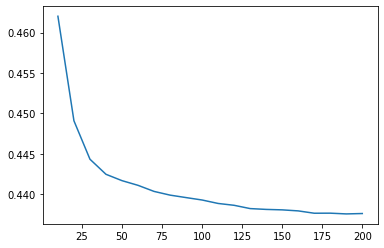

In [37]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

Answer: 170

#Question 4
Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

In [38]:
from tqdm.auto import tqdm

In [41]:
scores = []

for depth in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=depth,
                               random_state=2, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((depth, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

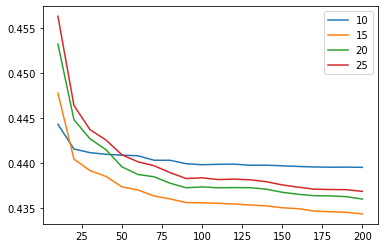

In [42]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

What's the best max_depth:

- 10
- 15
- 20
- 25

Answer: 15

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

Answer: No

# Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

- Train the model with these parametes:
 + n_estimators=10,
 + max_depth=20,
 + random_state=1,
 + n_jobs=-1 (optional)
- Get the feature importance information from this model

In [43]:
rf = RandomForestRegressor(n_estimators=10, max_depth=15, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=10, n_jobs=-1, random_state=1)

In [44]:
rf.feature_importances_

array([7.04097542e-02, 2.90648641e-02, 1.34108641e-01, 1.45886223e-01,
       4.99397733e-02, 1.87042804e-04, 1.17159749e-03, 3.89451321e-02,
       8.77868969e-04, 3.54601104e-05, 3.74652939e-02, 4.33267891e-02,
       4.38501330e-01, 3.51842718e-03, 6.56180262e-03])

In [45]:
df_importances = pd.DataFrame()
df_importances['feature'] = dict_vec.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,availability_365,0.070410
1,calculated_host_listings_count,0.029065
2,latitude,0.134109
3,longitude,0.145886
4,minimum_nights,0.049940
5,neighbourhood_group=Bronx,0.000187
6,neighbourhood_group=Brooklyn,0.001172
7,neighbourhood_group=Manhattan,0.038945
8,neighbourhood_group=Queens,0.000878
9,neighbourhood_group=Staten Island,0.000035


In [46]:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
12,room_type=Entire home/apt,0.438501
3,longitude,0.145886
2,latitude,0.134109
0,availability_365,0.070410
4,minimum_nights,0.049940


What's the most important feature?

- neighbourhood_group=Manhattan
- room_type=Entire home/apt
- longitude
- latitude

Answer: 	room_type=Entire home/apt

#Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

xgb_params = {
  
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [48]:
!pip install xgboost
import xgboost as xgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
scores = {}

In [49]:
features = dict_vec.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

In [50]:
%%capture output

xgb_params = {
    'eta': 0.03, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    #'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5
                  )

In [51]:
y_pred = model.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

0.43609056169873295

Now change eta first to 0.1 and then to 0.01

In [56]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    #'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5
                  )



In [57]:
y_pred = model.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

0.43289508475075533


In [59]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    #'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5
                  )



In [60]:
y_pred = model.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

0.729555872774987

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- 0.01

Answer: 0.1